In [1]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable

from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.utils

import numpy as np
import pandas as pd 
import time
import copy
import os

import matplotlib.pyplot as plt
import PIL.ImageOps  
from PIL import Image
import torch

### Additional Utility Functions 

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
batch_size = 32
epochs = 20

In [4]:
training_dir="../input/sign_data/sign_data/train"
training_csv="../input/sign_data/sign_data/train_data.csv"
testing_csv="../input/sign_data/sign_data/test_data.csv"
testing_dir="../input/sign_data/sign_data/test"

In [5]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [6]:
train_dataset = SiameseNetworkDataset(training_csv,training_dir,transform=transforms.Compose
                                        ([transforms.Resize((105,105)),transforms.ToTensor()]))

train_dataloader = DataLoader(train_dataset,shuffle=True, num_workers=8,batch_size=batch_size)

test_dataset = SiameseNetworkDataset(testing_csv,testing_dir,
                                     transform=transforms.Compose([transforms.Resize((105,105)),transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

## Siamese Network Definition

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn1 = nn.Sequential(           
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3))
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),         
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128,2))
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        
        return output1, output2


### Loss Function

In [8]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

### Train the Model

In [9]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [10]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [11]:
model = train()
torch.save(model.state_dict(), "model.pt")

Epoch number 0
 Current loss 1.1195931434631348

Epoch number 0
 Current loss 1.3219841718673706

Epoch number 0
 Current loss 1.3719422817230225

Epoch number 0
 Current loss 1.3441439867019653

Epoch number 0
 Current loss 1.350602388381958

Epoch number 0
 Current loss 1.0790610313415527

Epoch number 0
 Current loss 1.3154447078704834

Epoch number 0
 Current loss 1.411071538925171

Epoch number 0
 Current loss 0.8619049787521362

Epoch number 0
 Current loss 1.2627346515655518

Epoch number 0
 Current loss 1.1738965511322021

Epoch number 0
 Current loss 1.0792310237884521

Epoch number 0
 Current loss 1.2518727779388428

Epoch number 0
 Current loss 1.1486440896987915

Epoch number 0
 Current loss 1.1171746253967285

Epoch number 1
 Current loss 1.1984732151031494

Epoch number 1
 Current loss 1.1756623983383179

Epoch number 1
 Current loss 1.4787896871566772

Epoch number 1
 Current loss 1.3478131294250488

Epoch number 1
 Current loss 1.3858705759048462

Epoch number 1
 Curren

In [12]:
# Load the saved model
device = torch.device('cuda')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))

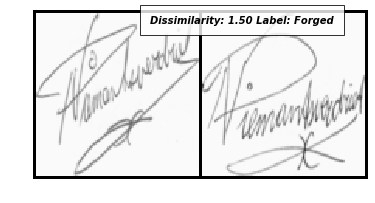

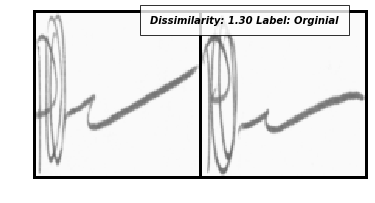

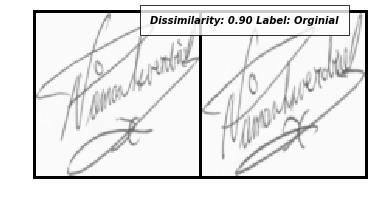

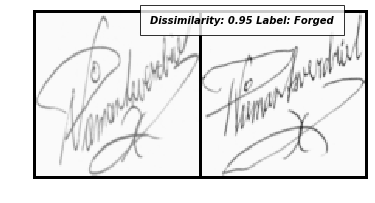

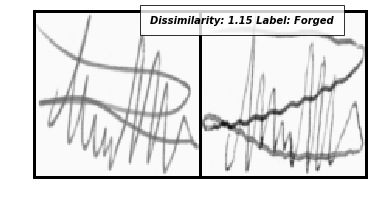

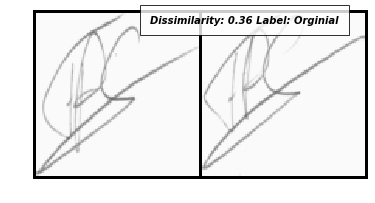

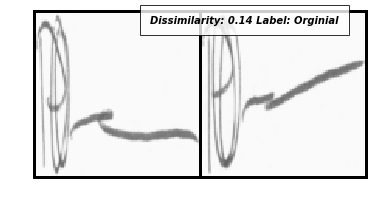

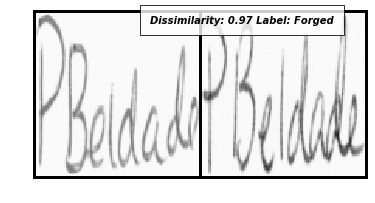

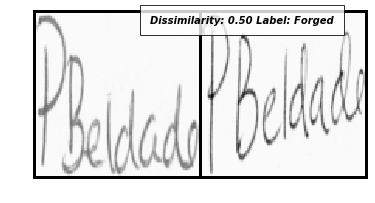

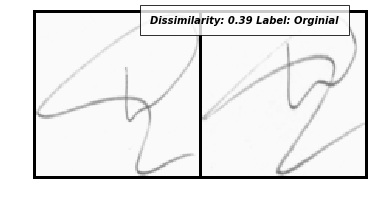

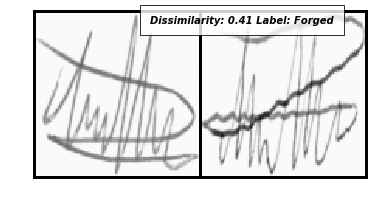

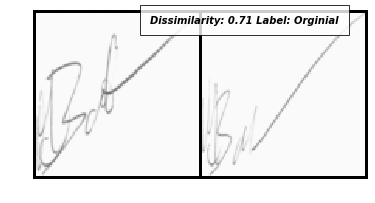

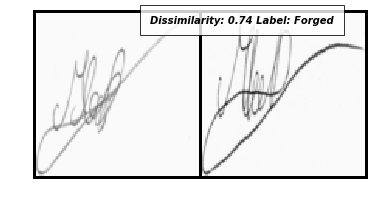

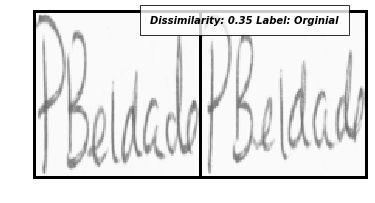

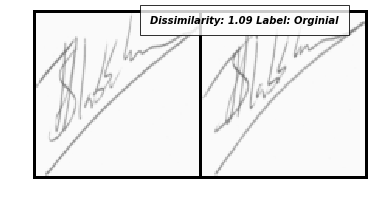

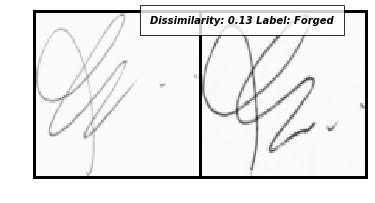

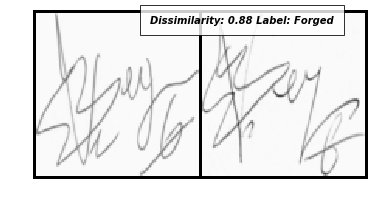

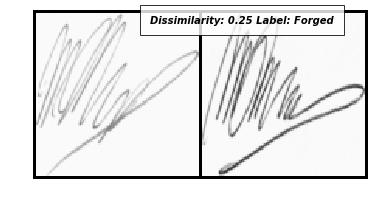

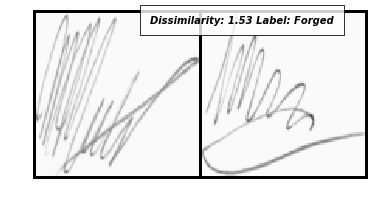

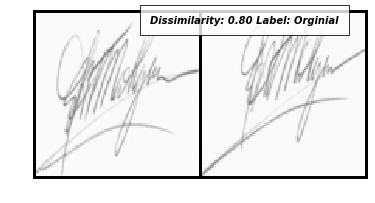

In [13]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    if label==list_0:
        label="Orginial"
    else:
        label="Forged"
    
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
    if counter ==20:
        break